[*********************100%***********************]  1 of 1 completed


Augmented Dickey-Fuller Test: Log-Transformed Prices
ADF Test Statistic: -0.63906677023158
p-value: 0.8619079833938081
#Lags Used: 0
Number of Observations: 3634
The series is non-stationary (fail to reject null hypothesis).
--------------------------------------------------
Augmented Dickey-Fuller Test: Differenced Log Prices
ADF Test Statistic: -60.34487790897585
p-value: 0.0
#Lags Used: 0
Number of Observations: 3633
The series is stationary (reject null hypothesis).
--------------------------------------------------


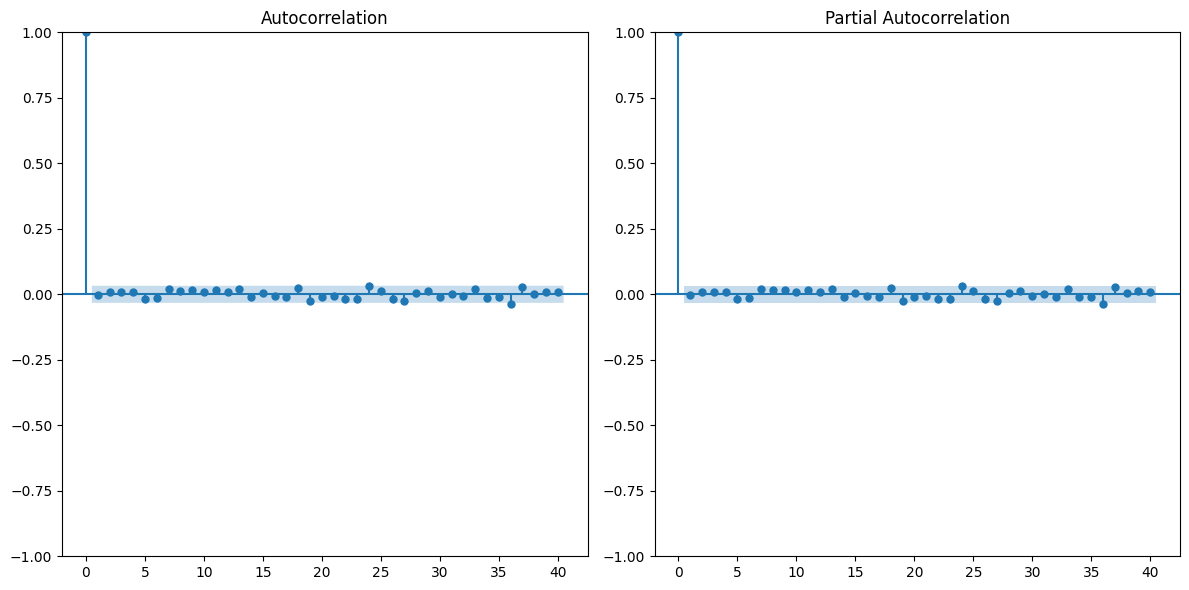

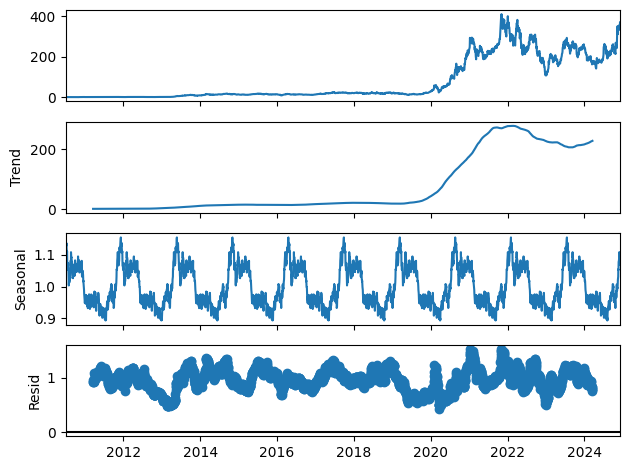

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

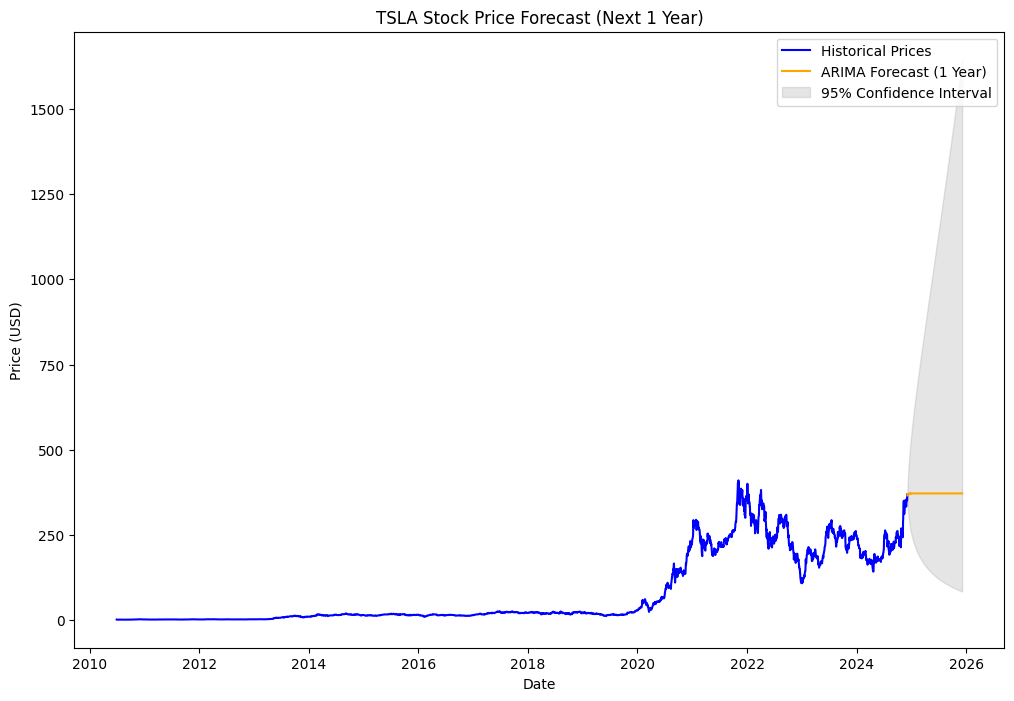

            Forecast_Price    Lower_CI     Upper_CI
Date                                               
2024-12-06      369.224314  344.172319   396.099822
2024-12-07      365.535320  330.975183   403.704195
2024-12-08      365.465722  323.496930   412.879324
2024-12-09      366.355313  318.032811   422.020027
2024-12-10      367.209437  313.258878   430.451552
...                    ...         ...          ...
2025-12-01      371.678460   84.703764  1630.917820
2025-12-02      371.678460   84.529636  1634.277442
2025-12-03      371.678460   84.356107  1637.639308
2025-12-04      371.678460   84.183174  1641.003424
2025-12-05      371.678460   84.010834  1644.369793

[365 rows x 3 columns]


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from datetime import datetime, timedelta

# ADF Test Function
def adfuller_test(series, title=""):
    print(f"Augmented Dickey-Fuller Test: {title}")
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations']
    for value, label in zip(result, labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("The series is stationary (reject null hypothesis).")
    else:
        print("The series is non-stationary (fail to reject null hypothesis).")
    print("-" * 50)

# Step 1: Download Apple stock data
ticker = "TSLA"
data = yf.download(ticker, start="2010-01-01", end=datetime.today().strftime('%Y-%m-%d'))
data = data[['Close']]  # Using 'Close' prices
data.rename(columns={'Close': 'Price'}, inplace=True)

# Step 2: Check stationarity and plot autocorrelation & partial autocorrelation
log_data = np.log(data['Price'])  # Log transformation for stability
adfuller_test(log_data, title="Log-Transformed Prices")

# Differencing the data for stationarity
log_diff = log_data.diff().dropna()
adfuller_test(log_diff, title="Differenced Log Prices")

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Autocorrelation Function (ACF)")
sm.graphics.tsa.plot_acf(log_diff, lags=40, ax=plt.gca())

plt.subplot(122)
plt.title("Partial Autocorrelation Function (PACF)")
sm.graphics.tsa.plot_pacf(log_diff, lags=40, ax=plt.gca())
plt.tight_layout()
plt.show()

# Step 3: Decompose time series into trend, seasonality, and residuals
result = seasonal_decompose(data['Price'], model='multiplicative', period=365)
result.plot()
plt.show()

# Step 4: Fit ARIMA model
p, d, q = 5, 1, 0  # Adjust based on ACF/PACF and stationarity tests
model = ARIMA(log_data, order=(p, d, q))
fitted_model = model.fit()

# Step 5: Forecast for 365 days
forecast_steps = 365
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_index = [data.index[-1] + timedelta(days=i+1) for i in range(forecast_steps)]

# Convert forecast back to original scale
forecast_mean = np.exp(forecast.predicted_mean)
forecast_ci = np.exp(forecast.conf_int())

# Step 6: Plot the results
plt.figure(figsize=(12, 8))
plt.plot(data['Price'], label="Historical Prices", color="blue")
plt.plot(forecast_index, forecast_mean, label="ARIMA Forecast (1 Year)", color="orange")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2, label="95% Confidence Interval")
plt.title(f"{ticker} Stock Price Forecast (Next 1 Year)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Save the forecast results
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast_Price': forecast_mean,
    'Lower_CI': forecast_ci.iloc[:, 0],
    'Upper_CI': forecast_ci.iloc[:, 1]
})
forecast_df.set_index('Date', inplace=True)
print(forecast_df)
